In [1]:
!nvidia-smi

Mon Dec 18 14:42:56 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%pip install -U autotrain-advanced

In [3]:
!rm -rf /content/Dreambooth_SDXL

In [4]:
PROJECT_NAME = "Dreambooth_SDXL"
MODEL_NAME = "stabilityai/stable-diffusion-xl-base-1.0"
DATA_DIR = "/content/manish_photos"
REPO_ID = "kr-manish/text-to-image-sdxl-lora-manish"

In [2]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]

    w, h = imgs[0].size
    grid_w, grid_h = cols * w, rows * h
    grid = Image.new("RGB", size=(grid_w, grid_h))

    for i, img in enumerate(imgs):
        x = i % cols * w
        y = i // cols * h
        grid.paste(img, box=(x, y))

    return grid

import glob

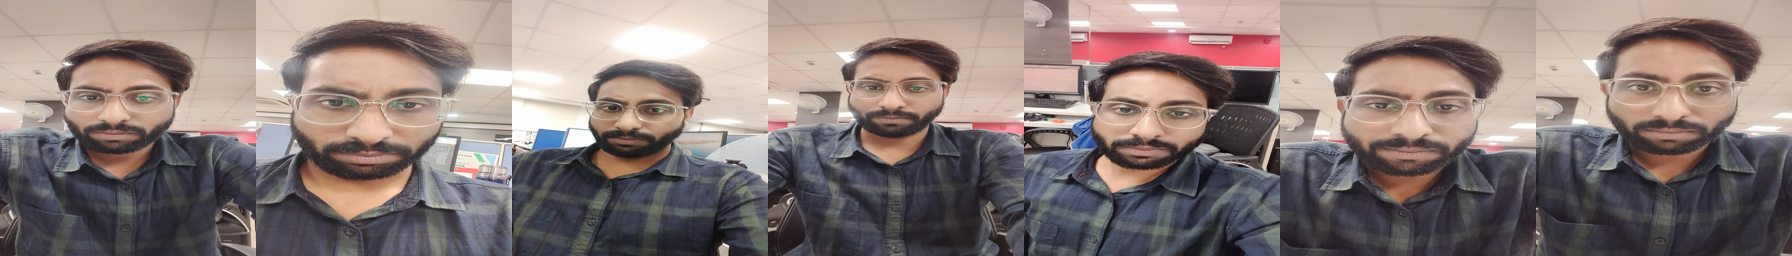

In [3]:
imgs = [Image.open(path) for path in glob.glob("/content/manish_photos/*.png")]
image_grid(imgs, 1, 7)

In [7]:
from huggingface_hub import notebook_login
notebook_login()

In [13]:
#!rm -rf /content/manish_photos

In [8]:
!autotrain dreambooth \
--model $MODEL_NAME \
--project-name $PROJECT_NAME \
--image-path $DATA_DIR \
--prompt "A photo of manish kumar wearing casual clothes, taking a selfie, and smiling." \
--resolution 1024 \
--batch-size 1 \
--num-steps 300 \
--gradient-accumulation 4 \
--lr 1e-4 \
--fp16 \
--gradient-checkpointing \
--push-to-hub \
--repo-id $REPO_ID


> INFO    Namespace(version=False, model='stabilityai/stable-diffusion-xl-base-1.0', revision=None, tokenizer=None, image_path='/content/manish_photos', class_image_path=None, prompt='A photo of manish kumar wearing casual clothes, taking a selfie, and smiling.', class_prompt=None, num_class_images=100, class_labels_conditioning=None, prior_preservation=None, prior_loss_weight=1.0, project_name='Dreambooth_SDXL', seed=42, resolution=1024, center_crop=None, train_text_encoder=None, batch_size=1, sample_batch_size=4, epochs=1, num_steps=300, checkpointing_steps=100000, resume_from_checkpoint=None, gradient_accumulation=4, gradient_checkpointing=True, lr=0.0001, scale_lr=None, scheduler='constant', warmup_steps=0, num_cycles=1, lr_power=1.0, dataloader_num_workers=0, use_8bit_adam=None, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.01, adam_epsilon=1e-08, max_grad_norm=1.0, allow_tf32=None, prior_generation_precision=None, local_rank=-1, xformers=None, pre_compute_text_embeddings=

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

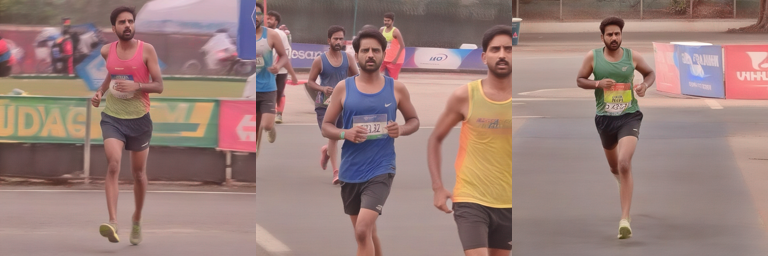

In [4]:
from diffusers import DiffusionPipeline, AutoencoderKL, StableDiffusionXLImg2ImgPipeline

import torch

vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix",
    torch_dtype=torch.float16
)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)
pipe.to("cuda");
#pipe.load_lora_weights(REPO_ID, weight_name="pytorch_lora_weights.safetensors")
pipe.load_lora_weights("/content/Dreambooth_SDXL", weight_name="/content/Dreambooth_SDXL/pytorch_lora_weights.safetensors")


prompt = "A photo of manish kumar participating in a marathon."

image = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt = 3)
image_grid(image.images, 1, 3)

In [15]:
import gc
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/25 [00:00<?, ?it/s]

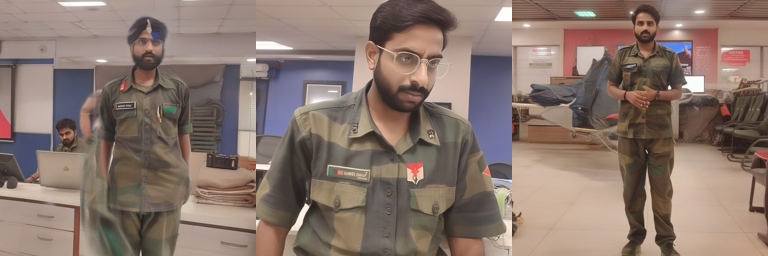

In [5]:
#prompt = "A photo of manish kumar giving a press conference."
prompt = "A photo of manish kumar waring  a indian army clothes."

image = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt = 3)
image_grid(image.images, 1, 3)

  0%|          | 0/25 [00:00<?, ?it/s]

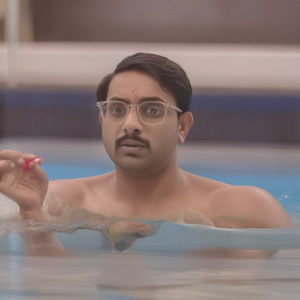

In [6]:
prompt = "A photo of manish kumar swimming in bikni."

seed = 65
generator = torch.Generator("cuda").manual_seed(seed)
image = pipe(prompt=prompt, num_inference_steps=25, generator=generator).images[0]
image.resize((300, 300))

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

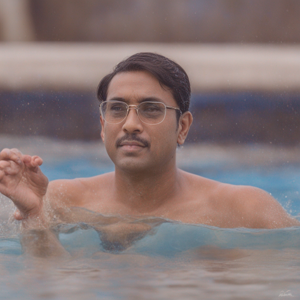

In [7]:
refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to("cuda");

image = refiner(prompt=prompt, num_inference_steps=25, generator=generator, image=image)
image.images[0].resize((300, 300))